In [1]:

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
import plotly.graph_objs as go
import plotly.offline as py
from zipfile import ZipFile #для архивации всей визуализации в один файл

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pochta-bank-branches/data.csv


In [2]:
file_path = '../input/pochta-bank-branches/data.csv'
data = pd.read_csv(file_path)

In [3]:
print(data.columns)
print(len(data.columns))

Index(['id', 'post_id', 'open_date', 'street', 'address', 'place_type',
       'shop_centre', 'dns', 'lat', 'lon', 'response', 'district', 'post2',
       'is_center', 'price', 'parking_count', 'parking_min_distance',
       'finance_count', 'shop_count', 'distance_100', 'distance_500',
       'cafe_count', 'culture_count', 'job_gov_count', 'metro_count',
       'metro_min_distance', 'transport_count', 'transport_min_distance',
       'working_days', 'work_hours', 'weekday_availability', 'office_hours',
       'is_moscow'],
      dtype='object')
33


In [4]:
#data.head()
print('\n','*'*70, '\n')
print(data.describe(include='all'))


 ********************************************************************** 

                  id        post_id    open_date          street  \
count     717.000000     545.000000   676.000000             717   
unique           NaN            NaN          NaN             503   
top              NaN            NaN          NaN   ул. Советская   
freq             NaN            NaN          NaN              10   
mean    12991.953975  126229.524771  2016.590237             NaN   
std      5855.130492   12844.670792     1.151807             NaN   
min      1327.000000  101000.000000  2012.000000             NaN   
25%      8835.000000  115598.000000  2016.000000             NaN   
50%     12755.000000  125310.000000  2017.000000             NaN   
75%     15649.000000  141205.000000  2017.000000             NaN   
max     27113.000000  144010.000000  2019.000000             NaN   

                          address place_type shop_centre    dns         lat  \
count                        

Описание всех полей в датасете
- post_id -- Почтовый индекс отделения от заказчика
- open_date -- Дата открытия отделения
- street -- Улица, выделенная из response
- address -- Адрес целиком, выделенный из response
- place_type -- Тип точки
- shop_centre -- Флаг нахождения в торговом центре
- dns -- Флаг нахождения в магазине DNS
- lat -- широта
- lon -- долгота
- response -- необработанный ответ геокодера, содержащий адрес
- district -- Округ, выделенный из response
- post2 -- Почтовый индекс, выделенный из response
- is_center -- Находится ли в центре Москвы
- price -- цена квадратного метра покупки жилья в районе Москвы/по городу вне Москвы
- parking_count -- количество парковок в ближайшей окрестности
- parking_min_distance -- минимальное расстояние до парковки (если есть рядом)
- finance_count -- количество финансовых учреждений в ближайшей окрестности
- shop_count -- количество магазинов в ближайшей окрестности
- distance_100 -- интенсивность человекопотока в окрестности 100 метров по gps трекам
- distance_500 -- интенсивность человекопотока в окрестности 500 метров по gps трекам- cafe_count -- количество кафе в ближайшей окрестности
- culture_count -- количество культурных объектов в ближайшей окрестности
- job_gov_count -- количество мест работы и государственных учреждений в ближайшей
окрестности
- metro_count -- количество станций метро в ближайшей окрестности
- metro_min_distance -- расстояние до ближайшей станции метро (если есть рядом)
- transport_count -- количество остановок в ближайшей окрестности
- transport_min_distance -- расстояние до ближайшей остановки (если есть рядом)
- working_days -- количество рабочих дней в неделе
- work_hours -- максимальная продолжительность рабочего дня в течение недели
- weekday_availability -- количество нерабочих дней на неделе
- office_hours -- строка с сырым временем работы отделения
- is_moscow -- флаг того, что город Москва

In [5]:
# Я чувствую, что многие столбцы мне просто не пригодятся
# Данные столбцы я скорее всего не переведу каким то образом в фичи или каким то другим способом получу пользу

to_delete = ['post_id', 'street', 'address', 'lat','lon', 'id', 'response', 'district', 'post2']

for i in to_delete:
    data.drop(i, axis=1, inplace=True)
print(data.describe(include='all'))

          open_date place_type shop_centre    dns is_center          price  \
count    676.000000        717         717    717       717     612.000000   
unique          NaN          5           2      2         2            NaN   
top             NaN   ОПС Б1_2       False  False     False            NaN   
freq            NaN        337         685    688       680            NaN   
mean    2016.590237        NaN         NaN    NaN       NaN  158229.890523   
std        1.151807        NaN         NaN    NaN       NaN   67721.704309   
min     2012.000000        NaN         NaN    NaN       NaN   17167.000000   
25%     2016.000000        NaN         NaN    NaN       NaN   94707.000000   
50%     2017.000000        NaN         NaN    NaN       NaN  155591.000000   
75%     2017.000000        NaN         NaN    NaN       NaN  227892.000000   
max     2019.000000        NaN         NaN    NaN       NaN  352119.000000   

        parking_count  parking_min_distance  finance_count  sho

In [6]:
# ok, теперь я вижу, что у нас есть колонки 3 типов: бинарная, категориальная и числовая. Следует их отделить друг от друга и хорошенько посмотреть.
max_count = data['shop_count'].count()
binary = list()
not_full = list()
for i in data.columns:
    if data[i].count() != max_count or data[i].isnull().sum() != 0 or data[i].isna().sum() != 0:
            not_full.append(i)
    
    if data[i].nunique() == 2:
        binary.append(i)
        
print(f"binary columns: {binary}")
print(f"not full columns: {not_full}")

binary columns: ['shop_centre', 'dns', 'is_center', 'is_moscow']
not full columns: ['open_date', 'price', 'parking_min_distance', 'metro_min_distance', 'transport_min_distance', 'office_hours']


In [7]:
print(data['price'].isna().sum())
count = 0
for i, k in zip(data['price'], data['is_moscow']):
    if (pd.isna(i) or pd.isnull(i)) and k==True:
        count += 1
print(f"this much data in Moscow and is nan {count}")
print(data['is_moscow'].value_counts())
print(f"number of unique types for placement types: {data.place_type.nunique()}")
print(f"they are: {data.place_type.unique()}")


105
this much data in Moscow and is nan 0
True     419
False    298
Name: is_moscow, dtype: int64
number of unique types for placement types: 5
they are: ['other' 'ТП' 'ОПС Б1' 'ОПС Б1_2' 'КЦ']


105 пустых значений в колонке цены недвижимости в районе это много, особенно учитывая, что они все не в Москве. Возможно это сельская или слабозаселенная местность.

Согласно инфомации с сайта администрации камчатского края о типах отделений почта банка\
https://viluchinsk-city.ru/about/info/projects/7390/

Есть следующие типы:
КЦ в ОПС (Б1_1 и Б1_2) – клиентский центр в ОПС, оснащенный банкоматом; обслуживание осуществляет сотрудник Банка.\
Формат «П1» – окно обслуживания в ОПС, оснащенное POS-терминалом, позволяющим осуществлять внесение и снятие наличных; обслуживание осуществляет сотрудник Почты России - агент Банка.\
Формат «П2» – размещение POS-терминала Банка на территории ОПС, с помощью которого возможно осуществление наиболее ограниченного числа операций.

Таким образом, насколько я понимаю, 'ОПС Б1' 'ОПС Б1_2' 'КЦ' можно отнести в одну категорию наиболее оснащенных отделений. Более подробную информацию о типах центров найти не удалось.\
Далее я планирую выделить несколько категорий и взять по ним средние значения, которыми я заполню пустые клетки.

In [8]:
data['place_type'] = data['place_type'].map({"ОПС Б1" : 0, "ОПС Б1_2" : 0, "КЦ" : 0, "ТП" : 1, "other" : 2})
print(data['place_type'].unique())
print(data['place_type'].value_counts())

[2 1 0]
0    583
1    105
2     29
Name: place_type, dtype: int64


In [9]:
#finally some nice means!!!
#data['place_type'].where(data['is_moscow']==False)
fil = data.loc[data['is_moscow'] == False, ['price','place_type']]
#fil['mns'] = fil.groupby(['place_type']).mean()
fil = fil.groupby(['place_type']).mean()
print(fil)

fil_dict = fil.T.to_dict(orient='list')
data['price'] = data['price'].fillna(data['place_type'].map(fil_dict))
#it = data['price'].fillna(data['place_type'].apply(lambda x: fil_dict.get(x)))
print(f"number of rows with null values: {data['price'].isnull().sum()}")

                   price
place_type              
0           78099.735294
1           72991.183673
2           77170.250000
number of rows with null values: 0


Проблему с ценой можно в целом считать решенной. Теперь следует обратить внимание на остальные колонки с отсутствующими значениями.

In [10]:
not_full.remove('price')
for i in not_full:
    print(f"for column: {i} number of rows with null values: {data[i].isnull().sum()}")

for column: open_date number of rows with null values: 41
for column: parking_min_distance number of rows with null values: 13
for column: metro_min_distance number of rows with null values: 563
for column: transport_min_distance number of rows with null values: 11
for column: office_hours number of rows with null values: 237


Теперь нужно разобраться с датой открытия. Вместо даты открытия введем возвраст офиса, то есть самому молодому офису будет 0 лет. А самому старому = max_year - min_year\
Поскольку пропусков в парковке немного, как и в минимальной дистанции до транспорта, можно усреднить пустые значения.\
С количеством часов все может быть чуть сложнее, скорее всего число часов работы опирается на тип точки. \
Число пропусков до метро огромное, возможно проблема в том, что в этом месте нет метро.

In [11]:
# посмотрим, сколько пустых значений не в Москве. Для Москвы можно заполнить средними значениями
count = 0
for i,k in zip(data['is_moscow'], data['metro_min_distance']):
    if i == False and (pd.isna(k) or pd.isnull(k)):
        count += 1
print(count)

298


In [12]:
fil = data.loc[data['is_moscow'] == True, ['metro_min_distance']]
mos_mean = fil.mean()
# если не Москва, то предположим, что метро находится на каком то очень большом расстоянии

fil_dict = ({True : mos_mean, False : 20})
data['metro_min_distance'] = data['metro_min_distance'].fillna(data['is_moscow'].map(fil_dict))
#it = data['price'].fillna(data['place_type'].apply(lambda x: fil_dict.get(x)))
print(f"number of rows with null values: {data['metro_min_distance'].isnull().sum()}")

number of rows with null values: 0


In [13]:
# данная переменная имеет слишком много разных значений, очень трудно будет как то перевести данный текст в категории. К тому же 237 пустых значений. Убираем.
print(len(data['office_hours'].unique()))
data.drop('office_hours', inplace=True, axis=1)

139


In [14]:
data['open_date']= pd.to_datetime(data['open_date'], format='%Y')
data.dtypes

open_date                 datetime64[ns]
place_type                         int64
shop_centre                         bool
dns                                 bool
is_center                           bool
price                             object
parking_count                      int64
parking_min_distance             float64
finance_count                      int64
shop_count                         int64
distance_100                     float64
distance_500                     float64
cafe_count                         int64
culture_count                      int64
job_gov_count                      int64
metro_count                        int64
metro_min_distance                object
transport_count                    int64
transport_min_distance           float64
working_days                     float64
work_hours                       float64
weekday_availability             float64
is_moscow                           bool
dtype: object

In [15]:
print(data['open_date'].min())
print(data['open_date'].max())
min_date = data['open_date'].min()
data['open_date'] = data['open_date'] - min_date
data['open_date'] = data['open_date'] / np.timedelta64(1, 'Y')
data['open_date'].head()

2012-01-01 00:00:00
2019-01-01 00:00:00


0    5.002156
1    3.000746
2    3.000746
3    5.002156
4    5.002156
Name: open_date, dtype: float64

In [16]:
print(data['open_date'].min())
print(data['open_date'].max())
data['open_date'].fillna(7, inplace=True)

0.0
7.000828216869614


In [17]:
data['parking_min_distance'].fillna(data['parking_min_distance'].mean(), inplace=True)
data['transport_min_distance'].fillna(data['transport_min_distance'].mean(), inplace=True)
not_full.remove('office_hours')
# проверим еще раз 
for i in not_full:
    print(f"for column: {i} number of rows with null values: {data[i].isnull().sum()}")

for column: open_date number of rows with null values: 0
for column: parking_min_distance number of rows with null values: 0
for column: metro_min_distance number of rows with null values: 0
for column: transport_min_distance number of rows with null values: 0


Теперь намного лучше, пустых значений нет, но есть большое количество float значений, хотелось бы их привести к int

In [18]:
to_delete.clear()
not_full.clear()

In [19]:
cols = [i for i in data.columns if i not in binary]
cols.remove('price')
cols.remove('metro_min_distance')

for i in cols:
    data[i] = data[i].astype(int)
    
cols_object = ('price', 'metro_min_distance')
for i in cols_object:
    #data[i] = data[i].astype(str).astype(int)
    #data[i] = data[i].convert_dtypes()
    #data[i] = data[i].to_numeric(data[i], errors='coerce')
    #data[i] = data[i].to_numeric(s, errors='coerce').convert_dtypes() 
    data[i] = data[i].apply(pd.to_numeric,errors="coerce")
    data[i] = data[i].astype(int)

print(data.dtypes)

open_date                 int64
place_type                int64
shop_centre                bool
dns                        bool
is_center                  bool
price                     int64
parking_count             int64
parking_min_distance      int64
finance_count             int64
shop_count                int64
distance_100              int64
distance_500              int64
cafe_count                int64
culture_count             int64
job_gov_count             int64
metro_count               int64
metro_min_distance        int64
transport_count           int64
transport_min_distance    int64
working_days              int64
work_hours                int64
weekday_availability      int64
is_moscow                  bool
dtype: object


**Визуализация данных**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



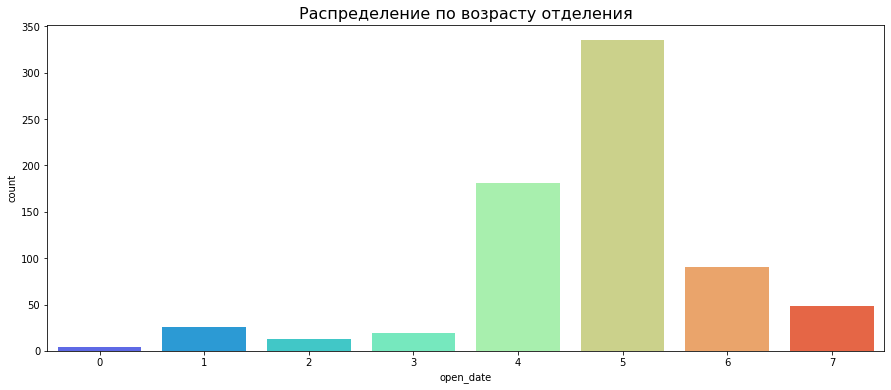

In [20]:

plt.rcParams['figure.figsize'] = (15, 6)
sns.countplot(data['open_date'], palette = 'rainbow')
plt.title('Распределение по возрасту отделения', fontsize = 16)
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



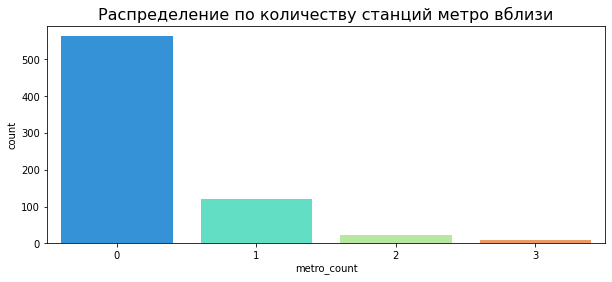

In [21]:
plt.rcParams['figure.figsize'] = (10, 4)
sns.countplot(data['metro_count'], palette = 'rainbow')
plt.title('Распределение по количеству станций метро вблизи', fontsize = 16)
plt.savefig('Распределение по количеству станций метро вблизи.jpg')
plt.show()


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



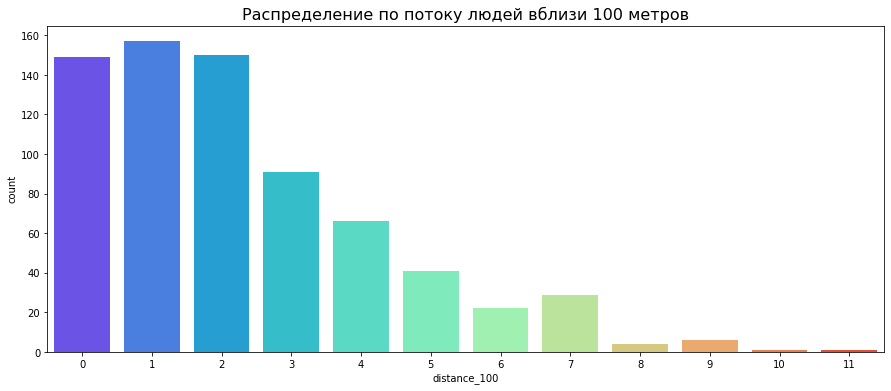

In [22]:
plt.rcParams['figure.figsize'] = (15, 6)
sns.countplot(data['distance_100'], palette = 'rainbow')
plt.title('Распределение по потоку людей вблизи 100 метров', fontsize = 16)
plt.savefig('Распределение по потоку людей вблизи 100 метров.jpg')
plt.show()


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



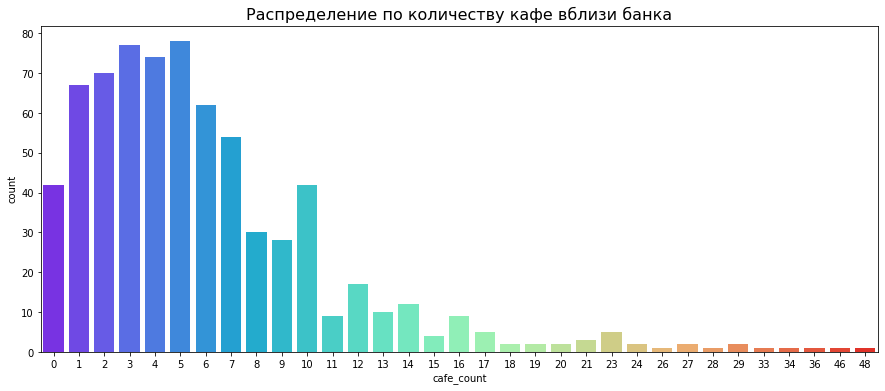

In [23]:
plt.rcParams['figure.figsize'] = (15, 6)
sns.countplot(data['cafe_count'], palette = 'rainbow')
plt.title('Распределение по количеству кафе вблизи банка', fontsize = 16)
plt.savefig('Распределение по количеству кафе вблизи банка.jpg')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



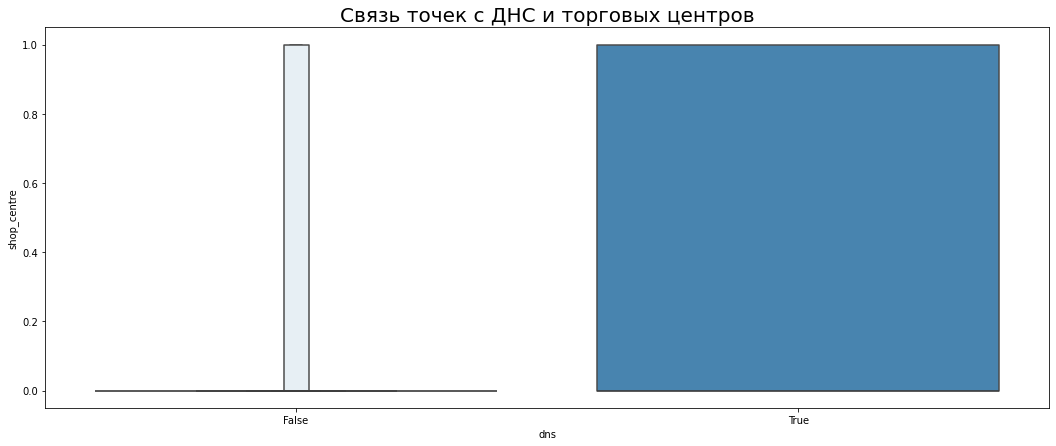

In [24]:
plt.rcParams['figure.figsize'] = (18, 7)
sns.boxenplot(data['dns'], data['shop_centre'], palette = 'Blues')
plt.title('Связь точек с ДНС и торговых центров', fontsize = 20)
plt.savefig('Связь точек с ДНС и торговых центров.jpg')
plt.show()

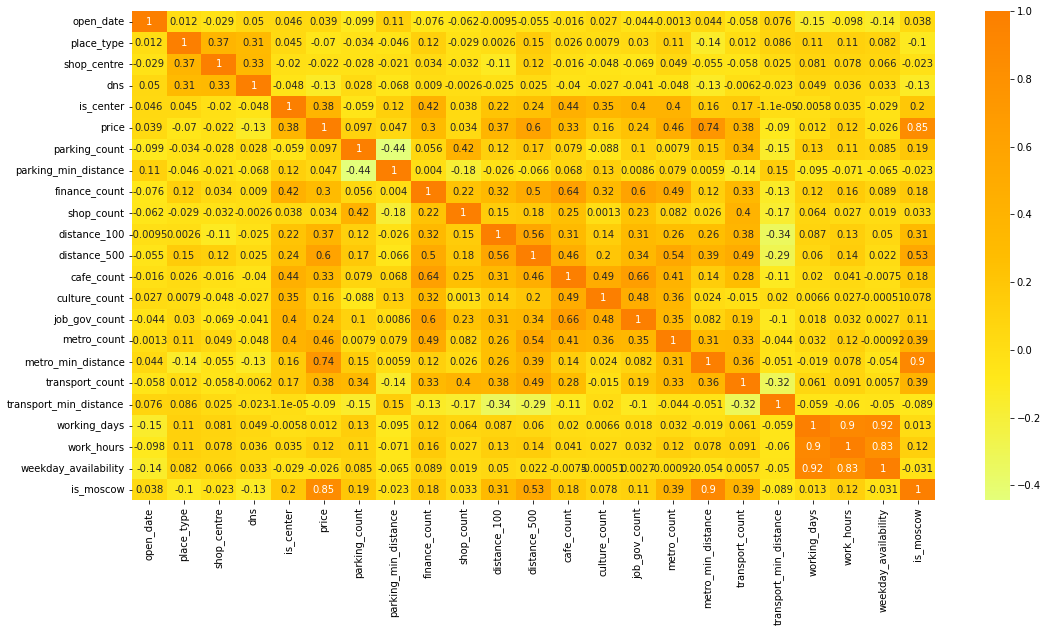

In [25]:
plt.rcParams['figure.figsize'] = (18, 9)
sns.heatmap(data.corr(), cmap = 'Wistia', annot = True)
plt.savefig('Матрица корреляций.jpg')
plt.show()


График с несколькими линиями из бинарных столбцов и потока людей в радиусе 100 метров. Как можно увидеть, что увеличение колечества торговых центров с увеличением расстояния в пределах 100 метров характерно для Москвы, при этом нет динамики в отношении магазинов DNS.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



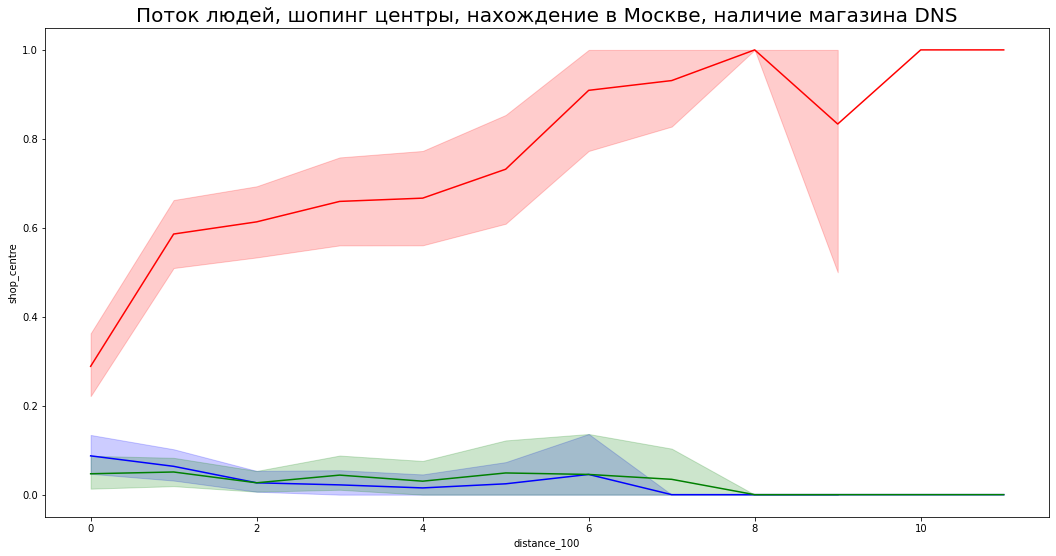

In [26]:
x = data['distance_100']
y = data['shop_centre']
z = data['is_moscow']
d = data['dns']

sns.lineplot(x, y, color = 'blue')
sns.lineplot(x, z, color = 'red')
sns.lineplot(x, d, color = 'green')

plt.title('Поток людей, шопинг центры, нахождение в Москве, наличие магазина DNS', fontsize = 20)
plt.savefig('Поток людей, шопинг центры, нахождение в Москве, наличие магазина DNS.jpg')
plt.show()


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



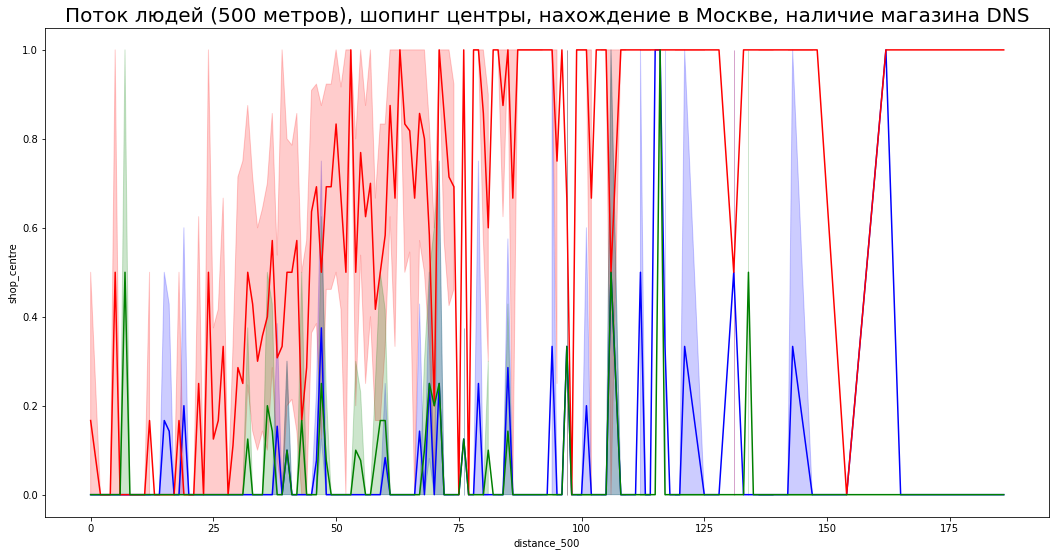

In [27]:
x = data['distance_500']
y = data['shop_centre']
z = data['is_moscow']
d = data['dns']

sns.lineplot(x, y, color = 'blue')
sns.lineplot(x, z, color = 'red')
sns.lineplot(x, d, color = 'green')

plt.title('Поток людей (500 метров), шопинг центры, нахождение в Москве, наличие магазина DNS', fontsize = 20)
plt.savefig('Поток людей (500 метров).jpg')
plt.show()
#plt.savefig('save_as_a_png.png')

Графики распределения потока показывают похожую картину и динамику, что для 100, что для 500 метров

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



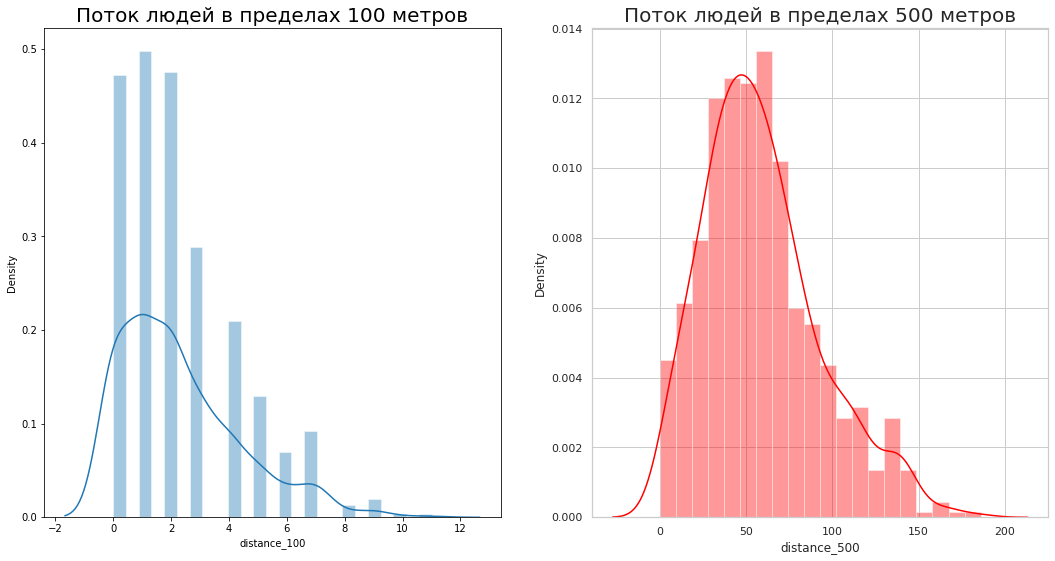

In [28]:

plt.subplot(1, 2, 1)
sns.set(style = 'whitegrid')
sns.distplot(data['distance_100'])
plt.title('Поток людей в пределах 100 метров', fontsize = 20)
plt.savefig('Поток людей в пределах 100 метров.jpg')

plt.subplot(1, 2, 2)
sns.set(style = 'whitegrid')
sns.distplot(data['distance_500'], color = 'red')
plt.title('Поток людей в пределах 500 метров', fontsize = 20)
plt.savefig('Поток людей в пределах 500 метров.jpg')
plt.show()


Можно заметить одинаковый паттерн рост и динамику в пределах 100 метров для всех инфраструктурных объектов.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning

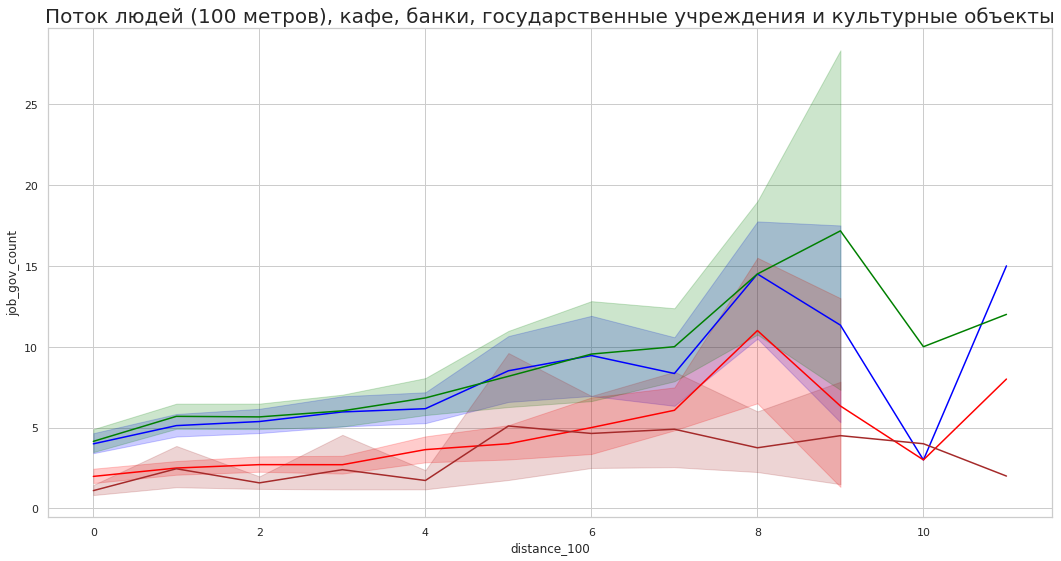

In [29]:
x = data['distance_100']
y = data['job_gov_count']
z = data['finance_count']
d = data['cafe_count']
g = data['culture_count']

sns.lineplot(x, y, color = 'blue')
sns.lineplot(x, z, color = 'red')
sns.lineplot(x, d, color = 'green')
sns.lineplot(x, g, color = 'brown')

plt.title('Поток людей (100 метров), кафе, банки, государственные учреждения и культурные объекты', fontsize = 20)
plt.savefig('Поток людей (100 метров), кафе, банки, государственные учреждения и культурные объекты.jpg')
plt.show()


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning

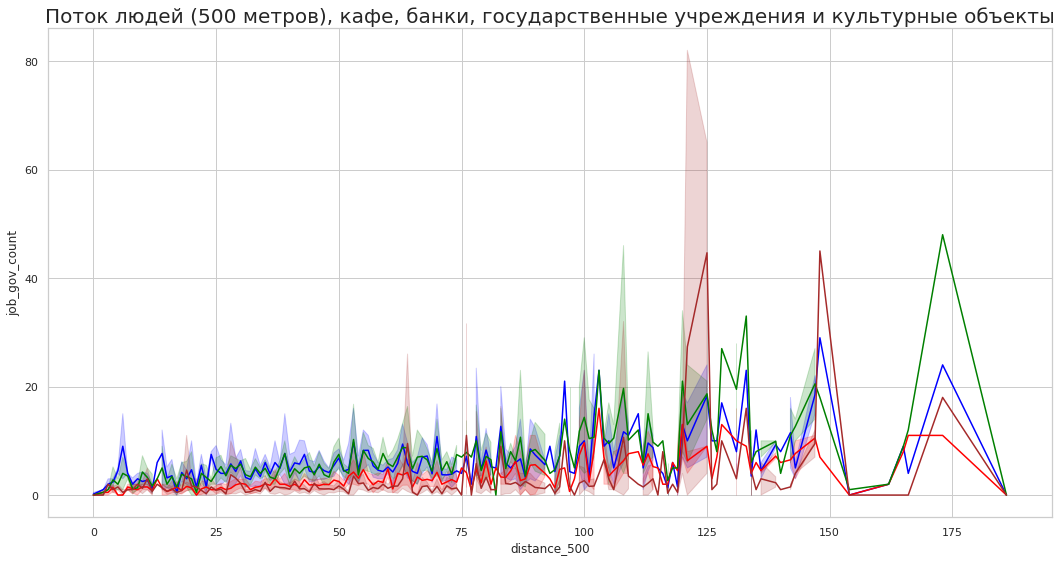

In [30]:
x = data['distance_500']
y = data['job_gov_count']
z = data['finance_count']
d = data['cafe_count']
g = data['culture_count']

sns.lineplot(x, y, color = 'blue')
sns.lineplot(x, z, color = 'red')
sns.lineplot(x, d, color = 'green')
sns.lineplot(x, g, color = 'brown')

plt.title('Поток людей (500 метров), кафе, банки, государственные учреждения и культурные объекты', fontsize = 20)
plt.savefig('Поток людей (500 метров), кафе, банки, государственные учреждения и культурные объекты.jpg')
plt.show()


**Кластеризация и поиск аномальных точек**

Поскольку я не вижу конкретных финансовых показателей или портрета клиента или колчество обработанных заявок, за самый важный показатель я буду принимать поток людей. Офис, чтобы считаться эффективным должен в первую очередь обрабатывать как можно большее количество заявок и клиентов и быть доступным в то же время для потенциальных клиентов, задумывающихся о начале использования услуг. 
Также можно заметить, что такие показали, как количество часов или число работчих дней, количество станций метро поблизости имеет маленькое влияние на поток потенциальных клиентов.


Матрица корреляций показывает, как для потока на расстоянии 100 метров, так и на расстоянии 500 метров наиболее сильную корреляцию с ценой на недвижимость, финансовыми учреждениями, расстоянием до метро, количеством остановок в ближайшей окресности и наличием кофе.

Таким образом попробуем ввести 3 метрики, на основе которых будем делать кластеризацию.
1. Транспортная доступность. Расстояние до метро и количество остановок.
2. Инфраструктура. Сумма банковских учреждений, кафе и гос учреждений.
3. Стоимость жилья. Можно назвать этот показатель престижностью.

In [31]:
col_names = data.columns
col_clust = ['price', 'cafe_count', 'job_gov_count', 'finance_count', 'metro_min_distance', 'transport_count']
mm_scaler = preprocessing.MinMaxScaler()
df_scaled = mm_scaler.fit_transform(data)
df_scaled = pd.DataFrame(df_scaled, columns=col_names)

clust = pd.DataFrame()
clust['houses'] = df_scaled['price']
clust['infrastructure'] = df_scaled['cafe_count'] + df_scaled['job_gov_count'] + df_scaled['finance_count']
clust['transport'] = df_scaled['metro_min_distance'] + df_scaled['transport_count']
print(clust.head())

     houses  infrastructure  transport
0  0.629120        0.769824   0.910892
1  0.629120        0.769824   0.910892
2  0.629120        1.026398   1.350304
3  0.629120        0.769824   0.910892
4  0.181913        0.291744   0.241379


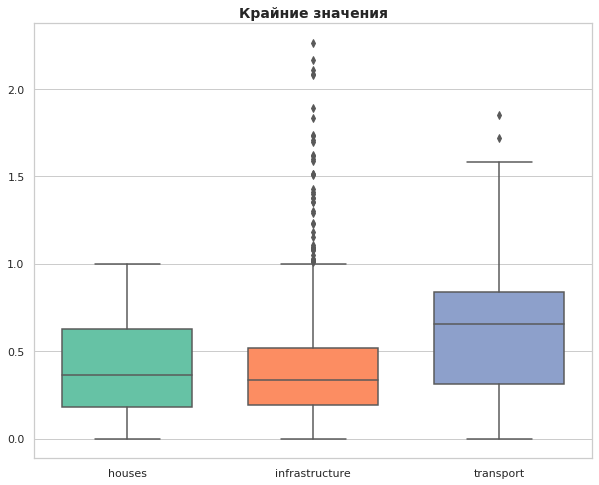

In [32]:
attributes = ['houses','infrastructure','transport']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = clust[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Крайние значения", fontsize = 14, fontweight = 'bold')
plt.savefig('Крайние значения.jpg')

Удалим аномальные значения

In [33]:
Q1 = clust.houses.quantile(0.05)
Q3 = clust.houses.quantile(0.95)
IQR = Q3 - Q1
clust = clust[(clust.houses >= Q1 - 1.5*IQR) & (clust.houses <= Q3 + 1.5*IQR)]

Q1 = clust.infrastructure.quantile(0.05)
Q3 = clust.infrastructure.quantile(0.95)
IQR = Q3 - Q1
clust = clust[(clust.infrastructure >= Q1 - 1.5*IQR) & (clust.infrastructure <= Q3 + 1.5*IQR)]

Q1 = clust.transport.quantile(0.05)
Q3 = clust.transport.quantile(0.95)
IQR = Q3 - Q1
clust = clust[(clust.transport >= Q1 - 1.5*IQR) & (clust.transport <= Q3 + 1.5*IQR)]


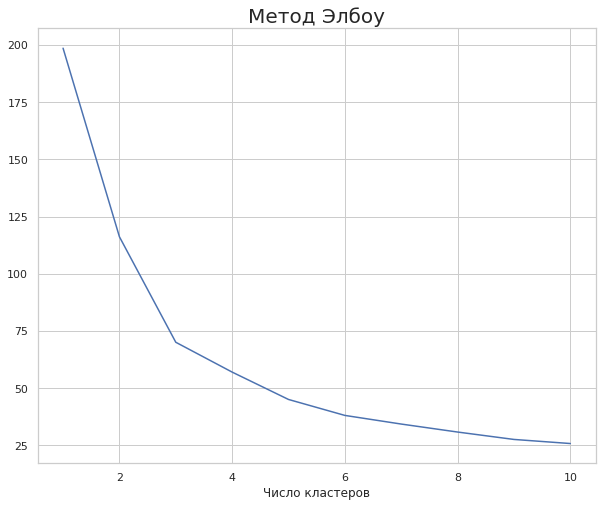

In [34]:
from sklearn.cluster import KMeans

info = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(clust)
    info.append(km.inertia_)
    
plt.plot(range(1, 11), info)
plt.title('Метод Элбоу', fontsize = 20)
plt.xlabel('Число кластеров')
plt.savefig('Метод Элбоу.jpg')
plt.show()


In [35]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(clust)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(clust, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.42318496879906176
For n_clusters=3, the silhouette score is 0.47012060309655423
For n_clusters=4, the silhouette score is 0.4442449858586548
For n_clusters=5, the silhouette score is 0.41146525821010005
For n_clusters=6, the silhouette score is 0.38692346435824737
For n_clusters=7, the silhouette score is 0.3816326012278544
For n_clusters=8, the silhouette score is 0.3523957083966692


In [36]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(clust)
kmeans.labels_
clust['Cluster_Id'] = kmeans.labels_
y_means = km.fit_predict(clust)
clust.head()

,houses,infrastructure,transport,Cluster_Id
0,0.629120,0.769824,0.910892,2
1,0.629120,0.769824,0.910892,2
2,0.629120,1.026398,1.350304,2
3,0.629120,0.769824,0.910892,2
4,0.181913,0.291744,0.241379,0


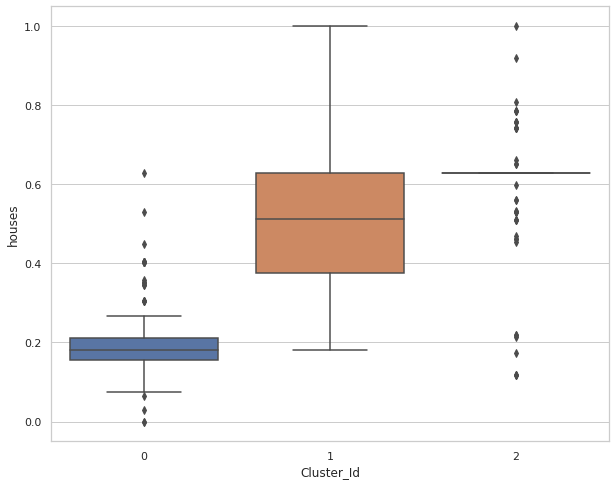

In [37]:
sns.boxplot(x='Cluster_Id', y='houses', data=clust)
plt.savefig('Кластеры - дома.jpg')

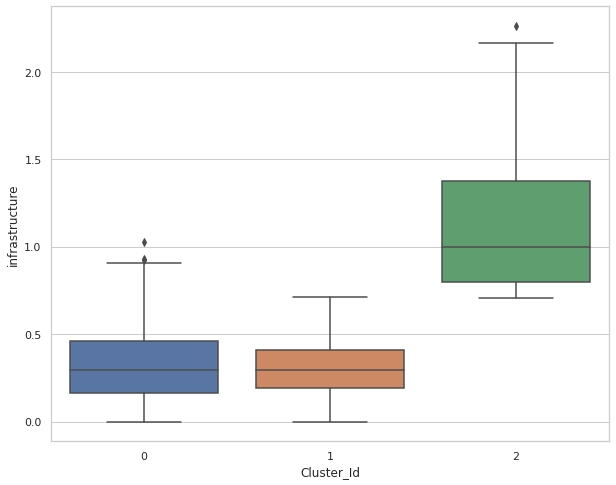

In [38]:
sns.boxplot(x='Cluster_Id', y='infrastructure', data=clust)
plt.savefig('Кластеры - инфраструктура.jpg')

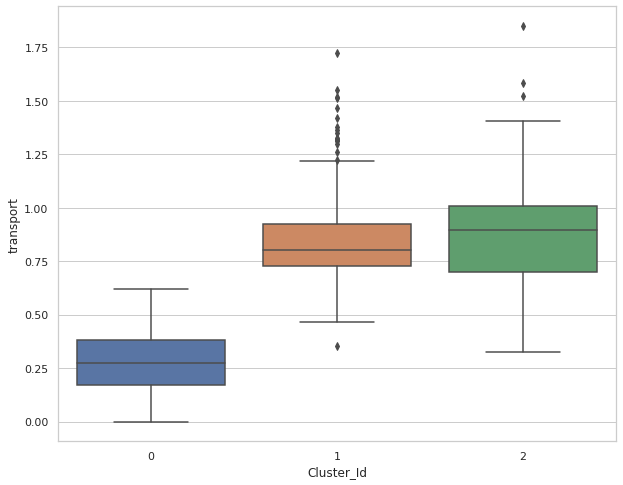

In [39]:
sns.boxplot(x='Cluster_Id', y='transport', data=clust)
plt.savefig('Кластеры - транспорт.jpg')

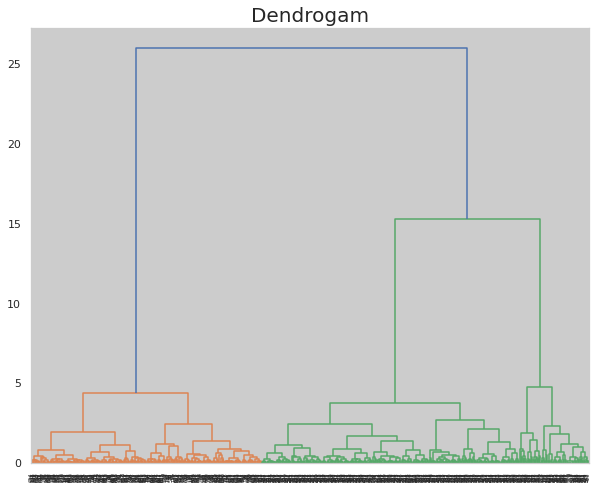

In [40]:
import scipy.cluster.hierarchy as sch
x = clust

dendrogram = sch.dendrogram(sch.linkage(x, method = 'ward'))
plt.title('Dendrogam', fontsize = 20)
plt.show()

In [41]:
trace1 = go.Scatter3d(
    x= clust['houses'],
    y= clust['infrastructure'],
    z= clust['transport'],
    mode='markers',
     marker=dict(
        color = clust['Cluster_Id'], 
        size= 9,
        line=dict(
            color= clust['Cluster_Id'],
            width= 14
        ),
        opacity=0.6
     )
)
df = [trace1]

layout = go.Layout(
    title = 'Кластеризация отделений',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0  
    ),
    scene = dict(
            xaxis = dict(title  = 'houses'),
            yaxis = dict(title  = 'infrastructure'),
            zaxis = dict(title  = 'transport')
        )
)

fig = go.Figure(data = df, layout = layout)
py.iplot(fig)


In [42]:
zipObj = ZipFile('all pictures.zip', 'w')

for filename in os.listdir("/kaggle/working"):
    if filename.endswith(".jpg"):
        zipObj.write(filename)
zipObj.close()
